In [1]:
import geopandas as gpd
import matplotlib.pyplot as plt

import pandas as pd
from datetime import datetime

import os
import ipywidgets as widgets

import tkinter as tk
from tkinter import filedialog as fd

## Leer catastro

In [2]:
# open file dialog
root = tk.Tk()
root.attributes('-topmost', True)
root.iconify()
file_name = fd.askopenfilename(parent=root, filetypes=[(".shp", ".shp")])
root.destroy()

In [3]:
file_name

'D:/OneDrive - Ingenio Azucarero Guabira S.A/UTEA_2023/CATASTRO/CATASTRO_2023-03-31.shp'

In [4]:
# leer el .shp seleccionado
data = gpd.read_file(file_name)

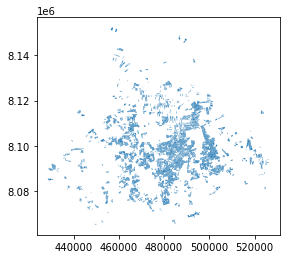

In [5]:
data.plot()
plt.show()

## Leer codigos de grupo